In [5]:
#Data Visualization
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn as sns

#Sharpening of images
from skimage.io import imshow, imread
from skimage.color import rgb2yuv, rgb2hsv, rgb2gray, yuv2rgb, hsv2rgb
from scipy.signal import convolve2d

#Preprocessing of Images
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

#Buliding Model
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

#Accuracy
from sklearn.metrics import classification_report

In [6]:
categories=['Healthy', 'Red Rot', 'Red Rust']
print(categories)

['Healthy', 'Red Rot', 'Red Rust']


In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
data_dir = '/content/drive/MyDrive/dataset/Training'

In [9]:
labels=[i for i in range(len(categories))]
labels

[0, 1, 2]

In [10]:
label_dict=dict(zip(categories, labels))
label_dict

{'Healthy': 0, 'Red Rot': 1, 'Red Rust': 2}

In [11]:
data_list=[]
labels_list=[]

In [12]:
data1="/content/drive/MyDrive/dataset/Training/Healthy"
data2="/content/drive/MyDrive/dataset/Training/Red Rot"
data3="/content/drive/MyDrive/dataset/Training/Red Rust"

count_healthy=0
count_redrot=0
count_redrust=0

In [13]:
for i in os.listdir(data1):
        img_path=os.path.join(data1, i)
        count_healthy=count_healthy+1

In [14]:
for i in os.listdir(data2):
        img_path=os.path.join(data2, i)
        count_redrot=count_redrot+1

In [15]:
for i in os.listdir(data3):
        img_path=os.path.join(data3, i)
        count_redrust=count_redrust+1

In [16]:
count_healthy,count_redrot,count_redrust

(418, 414, 412)

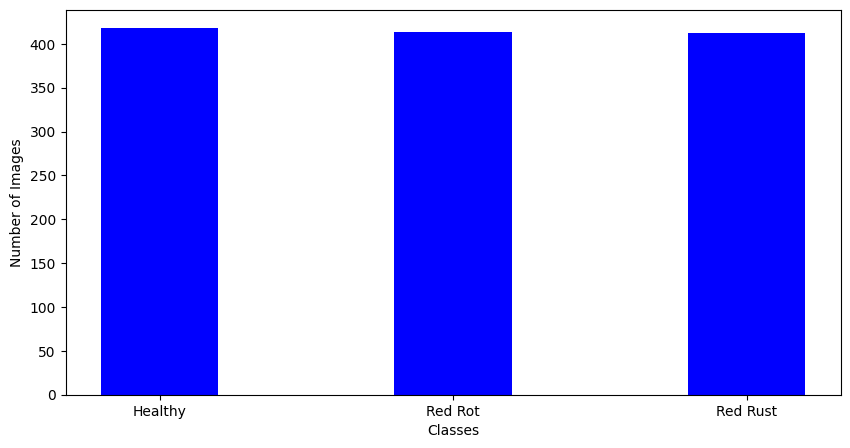

In [17]:
fig = plt.figure(figsize = (10, 5))
classes=["Healthy","Red Rot", "Red Rust"]
values=[count_healthy,count_redrot,count_redrust]
#creating the bar plot
plt.bar(classes, values, color ='blue',
        width = 0.4)

plt.xlabel("Classes")
plt.ylabel("Number of Images")
plt.show()

In [18]:
sharpen = np.array([[0, -1, 0],
                    [-1, 5, -1],
                    [0, -1, 0]])

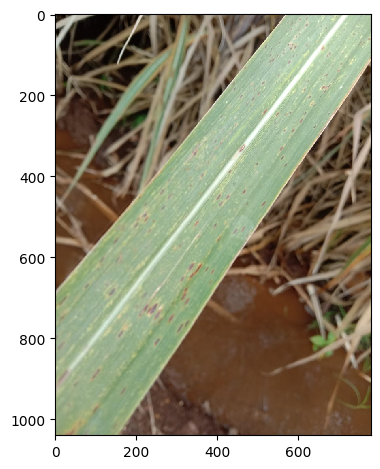

In [19]:
og_image = imread('/content/drive/MyDrive/rust (365).jpeg')
imshow(og_image);

In [20]:
def multi_convolver(image, kernel, iterations):
    for i in range(iterations):
        image = convolve2d(image, kernel, 'same', boundary = 'fill',
                           fillvalue = 0)
    return image

In [21]:
def convolver_rgb(image, kernel, iterations = 1):
    img_yuv = rgb2yuv(image)
    img_yuv[:,:,0] = multi_convolver(img_yuv[:,:,0], kernel,
                                     iterations)
    final_image = yuv2rgb(img_yuv)
    return final_image

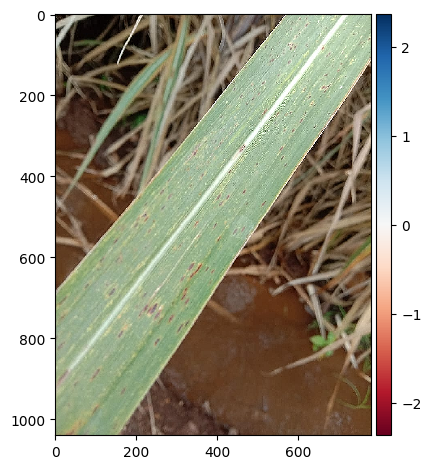

In [22]:
final_image = convolver_rgb(og_image, sharpen, iterations = 1)
imshow(final_image);

In [23]:
from PIL import Image
for i in categories:
    folder_path=os.path.join(data_dir, i) #path to each disease folder
    img_names=os.listdir(folder_path)   #all images in each disease folder
    for img_name in img_names:
        img_path=os.path.join(folder_path, img_name)
        if(img_path=='/content/drive/MyDrive/dataset/Training/Red Rust' or img_path=='/content/drive/MyDrive/dataset/Training/Red Rot' or img_path=='/content/drive/MyDrive/dataset/Training/Healthy'):
          continue
        img = Image.open(img_path)
        img = img.resize((224,224))
        img = np.array(img)
        img = convolver_rgb(img, sharpen, iterations = 1)
        data_list.append(img)
        labels_list.append(label_dict[i])

In [24]:
data_list[0].shape

(224, 224, 3)

In [25]:
lb = LabelEncoder()
labels_list = lb.fit_transform(labels_list)
labels_list = to_categorical(labels_list)

In [26]:
data = np.array(data_list)
labels = np.array(labels_list)
print("Done")
print(data.shape)

Done
(1244, 224, 224, 3)


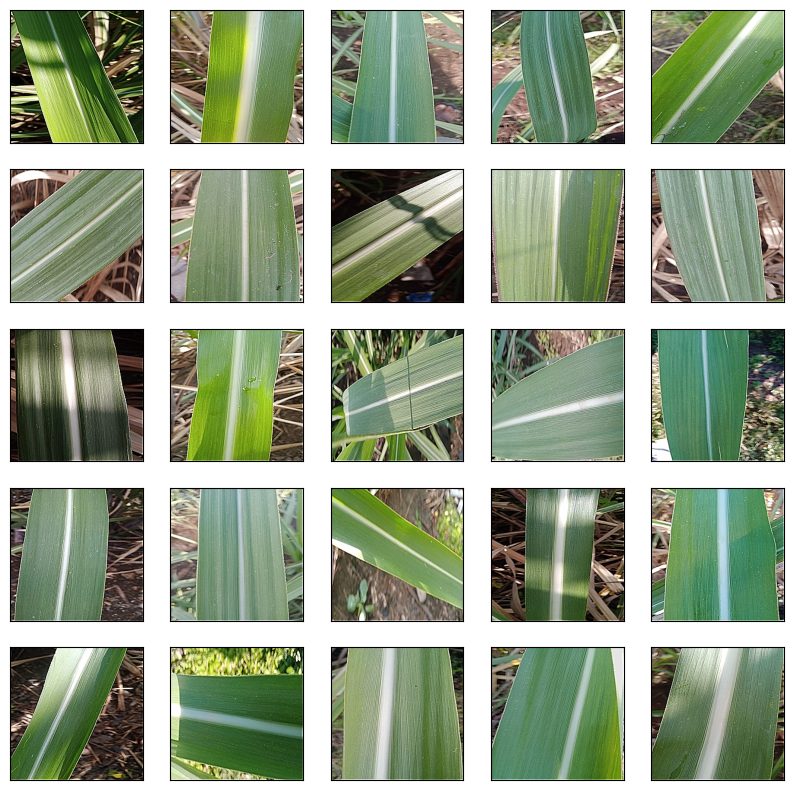

In [27]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(data[np.random.randint(224)], cmap=plt.cm.binary)

In [28]:
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

In [29]:
# Assuming data and labels are lists or arrays
if len(data) > len(labels):
    data = data[:-1]  # Remove one sample from data
elif len(labels) > len(data):
    labels = labels[:-1]  # Remove one label from labels

In [30]:
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.20, stratify=labels, random_state=42)

In [31]:
print( trainX.shape, testX.shape, trainY.shape, testY.shape)

(995, 224, 224, 3) (249, 224, 224, 3) (995, 3) (249, 3)


In [32]:
from keras.applications.densenet import DenseNet201
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense ,Dropout
from keras.layers import Input

In [33]:
base_model = DenseNet201(include_top=False,
                         input_shape=(224,224,3),
                         weights='imagenet',
                         pooling="avg"
                     )

In [34]:
from tensorflow.keras.regularizers import l2

In [35]:
base_model.trainable = False
image_input = Input(shape=(224, 224, 3))

x = base_model(image_input,training = False)

x = Dense(256,activation = "relu")(x)
x = Dropout(0.2)(x)

x = Dense(128,activation = "relu")(x)
x = Dropout(0.2)(x)

image_output = Dense(3,kernel_regularizer=l2(0.01),activation="softmax")(x) #output layer
#kernel Regulariser- SVM

model = Model(image_input,image_output)
model.compile(optimizer="adam",loss="squared_hinge",metrics=["accuracy"])
#loss function is square hinged- SVM

In [36]:
from tensorflow.keras.regularizers import l2

In [37]:
from tensorflow.keras.utils import plot_model

In [38]:
BS=32
EPOCHS=10

In [39]:
history = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)

Epoch 1/10
31/31 [==============================] - 349s 11s/step - loss: 1.1237 - accuracy: 0.6667 - val_loss: 0.9550 - val_accuracy: 0.8193
Epoch 2/10
31/31 [==============================] - 337s 11s/step - loss: 0.9663 - accuracy: 0.7975 - val_loss: 0.9354 - val_accuracy: 0.8233
Epoch 3/10
31/31 [==============================] - 322s 10s/step - loss: 0.8800 - accuracy: 0.8764 - val_loss: 0.9629 - val_accuracy: 0.7871
Epoch 4/10
31/31 [==============================] - 338s 11s/step - loss: 0.8617 - accuracy: 0.8879 - val_loss: 0.8169 - val_accuracy: 0.9197
Epoch 5/10
31/31 [==============================] - 312s 10s/step - loss: 0.8077 - accuracy: 0.9252 - val_loss: 0.7997 - val_accuracy: 0.9277
Epoch 6/10
31/31 [==============================] - 318s 10s/step - loss: 0.8233 - accuracy: 0.9107 - val_loss: 0.8402 - val_accuracy: 0.8835
Epoch 7/10
31/31 [==============================] - 288s 9s/step - loss: 0.7966 - accuracy: 0.9283 - val_loss: 0.7961 - val_accuracy: 0.9237
Epoch 8

In [40]:
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs))

[INFO] evaluating network...
8/8 [==============================] - 62s 7s/step
              precision    recall  f1-score   support

           0       0.99      0.99      0.99        84
           1       0.95      0.90      0.93        83
           2       0.92      0.96      0.94        82

    accuracy                           0.95       249
   macro avg       0.95      0.95      0.95       249
weighted avg       0.95      0.95      0.95       249



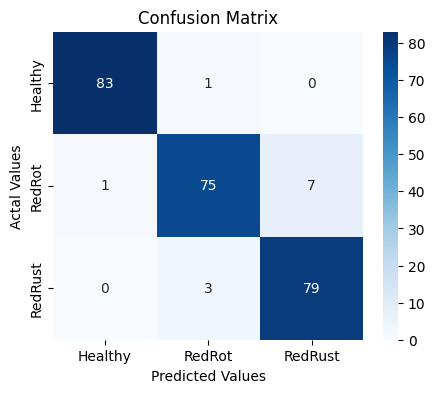

In [41]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(testY.argmax(axis=1), predIdxs)


cm_df = pd.DataFrame(cm,
                     index = ['Healthy','RedRot','RedRust'],
                     columns = ['Healthy','RedRot','RedRust'])
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

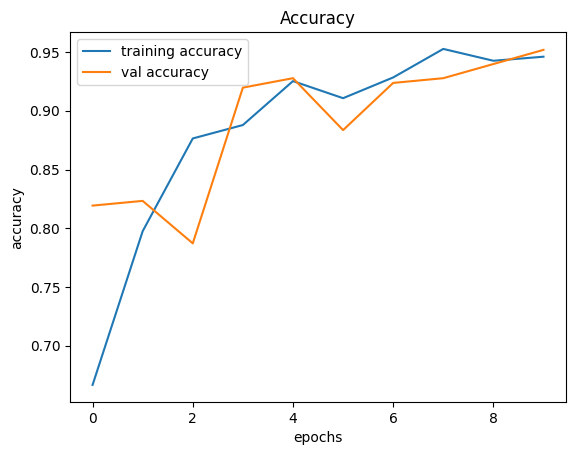

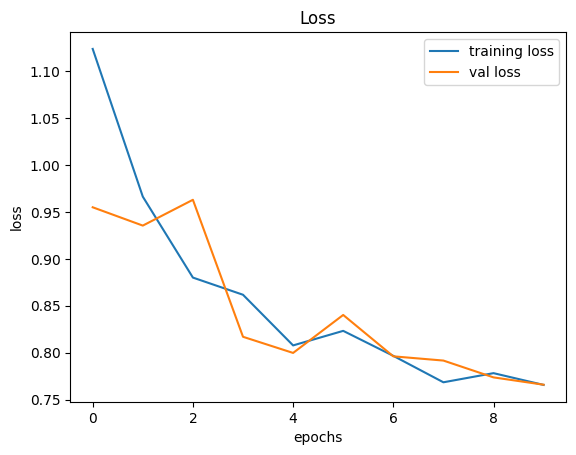

In [42]:
import matplotlib.pyplot as plt
plt.figure(0)

plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

plt.figure(1)
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

1/1 [==============================] - 1s 617ms/step


[[9.1330448e-06 1.0169584e-03 9.9897397e-01]]
2


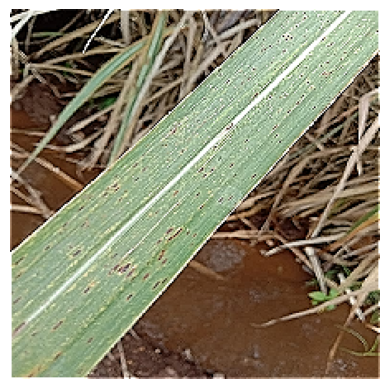

Disease detected: Red Rust


In [46]:
from keras.preprocessing import image
import matplotlib.pyplot as plt

img = image.load_img("/content/drive/MyDrive/rust (365).jpeg", target_size=(224,224))
x = image.img_to_array(img)
x=x/255
img = convolver_rgb(img, sharpen, iterations = 1)
x=x.reshape(224,224,3)
x = np.expand_dims(x, axis=0)


predi=model.predict(x)
print(predi)
classes_x=np.argmax(predi)
print(classes_x)

# Display the image
plt.imshow(img)
plt.axis('off')  # Hide axes
plt.show()

classes=["Healthy","Red Rot", "Red Rust"]
prediction_label=prediction_label=classes[classes_x]
if(prediction_label=="Healthy"):
  print("It is a Healthy Leaf")
else:
  print("Disease detected: "+prediction_label)

In [44]:
model.save("DenseNetSVM_Modelnew.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
